# Data Modelling

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plot_utils import save_plot_to_png
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertTokenizer, BertModel
import string
import torch
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

In [50]:
city = 'brighton'
df = pd.read_csv('./Data/brighton_data_processed.csv')

In [51]:
df.head()

,price,house_type,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,tenure,lease_time,service_charge,tax_band,...,latitude,longitude,school_1_distance,school_2_distance,train_1_distance,train_2_distance,has_garden,has_parking,old_new,word_count
0,300000.0,flat,2,1,1,639.4,share of freehold,35.8,1100.0,A,...,50.834835,-0.136658,0.2,0.3,0.1,0.4,0,0,Y,266
1,295000.0,flat,1,1,1,502.8,not available,622.8,1292.4,unknown,...,50.828022,-0.136807,0.1,0.3,0.5,1.0,0,0,Y,120
2,450000.0,terraced house,3,1,2,1030.0,freehold,0.0,1633.0,C,...,50.860744,-0.131786,0.3,0.4,1.1,1.3,0,0,Y,322
3,425000.0,maisonette,2,1,1,632.0,leasehold,120.0,1765.4,unknown,...,50.834766,-0.135156,0.2,0.3,0.1,0.5,0,0,Y,239
4,220000.0,flat,1,1,1,529.6,leasehold,117.0,1002.4,A,...,50.823853,-0.148882,0.1,0.3,0.5,1.0,0,0,Y,590


In [52]:
description = df.describe().round(2).transpose()

In [53]:
description

,count,mean,std,min,25%,50%,75%,max
price,4271.0,473493.84,265839.66,80000.00,299950.00,420000.00,575000.00,2000000.00
number_of_bedrooms,4271.0,2.72,1.18,1.00,2.00,3.00,3.00,7.00
number_of_bathrooms,4271.0,1.47,0.65,1.00,1.00,1.00,2.00,4.00
number_of_receptions,4271.0,1.41,0.64,1.00,1.00,1.00,2.00,4.00
property_size,4271.0,978.59,350.59,241.00,635.10,944.40,1242.40,2194.00
lease_time,4271.0,93.13,200.65,0.00,0.00,0.00,97.00,996.00
service_charge,4271.0,1886.50,630.00,1.00,1518.70,1936.80,2175.50,4445.40
ground_rent,4271.0,49.92,88.22,0.00,0.00,0.00,62.60,360.00
latitude,4271.0,50.69,0.65,47.34,50.81,50.82,50.83,56.56
longitude,4271.0,-1.12,3.93,-18.28,-0.34,-0.20,-0.12,8.22


In [54]:
description.to_excel('./Data/brighton_dataset_description.xlsx', engine='openpyxl')

In [55]:
# renaming target column
cols = list(df.columns)
cols[0] = 'price_target'
df.columns = cols
df.head()

,price_target,house_type,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,tenure,lease_time,service_charge,tax_band,...,latitude,longitude,school_1_distance,school_2_distance,train_1_distance,train_2_distance,has_garden,has_parking,old_new,word_count
0,300000.0,flat,2,1,1,639.4,share of freehold,35.8,1100.0,A,...,50.834835,-0.136658,0.2,0.3,0.1,0.4,0,0,Y,266
1,295000.0,flat,1,1,1,502.8,not available,622.8,1292.4,unknown,...,50.828022,-0.136807,0.1,0.3,0.5,1.0,0,0,Y,120
2,450000.0,terraced house,3,1,2,1030.0,freehold,0.0,1633.0,C,...,50.860744,-0.131786,0.3,0.4,1.1,1.3,0,0,Y,322
3,425000.0,maisonette,2,1,1,632.0,leasehold,120.0,1765.4,unknown,...,50.834766,-0.135156,0.2,0.3,0.1,0.5,0,0,Y,239
4,220000.0,flat,1,1,1,529.6,leasehold,117.0,1002.4,A,...,50.823853,-0.148882,0.1,0.3,0.5,1.0,0,0,Y,590


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4271 entries, 0 to 4270
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price_target          4271 non-null   float64
 1   house_type            4271 non-null   object 
 2   number_of_bedrooms    4271 non-null   int64  
 3   number_of_bathrooms   4271 non-null   int64  
 4   number_of_receptions  4271 non-null   int64  
 5   property_size         4271 non-null   float64
 6   tenure                4271 non-null   object 
 7   lease_time            4271 non-null   float64
 8   service_charge        4271 non-null   float64
 9   tax_band              4271 non-null   object 
 10  ground_rent           4271 non-null   float64
 11  description_text      4271 non-null   object 
 12  postcode              4271 non-null   object 
 13  latitude              4271 non-null   float64
 14  longitude             4271 non-null   float64
 15  school_1_distance    

In [9]:
# df.drop(columns=['word_count'], inplace=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4271 entries, 0 to 4270
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price_target          4271 non-null   float64
 1   house_type            4271 non-null   object 
 2   number_of_bedrooms    4271 non-null   int64  
 3   number_of_bathrooms   4271 non-null   int64  
 4   number_of_receptions  4271 non-null   int64  
 5   property_size         4271 non-null   float64
 6   tenure                4271 non-null   object 
 7   lease_time            4271 non-null   float64
 8   service_charge        4271 non-null   float64
 9   tax_band              4271 non-null   object 
 10  ground_rent           4271 non-null   float64
 11  description_text      4271 non-null   object 
 12  postcode              4271 non-null   object 
 13  latitude              4271 non-null   float64
 14  longitude             4271 non-null   float64
 15  school_1_distance    

## Normalization of numerical data

In [58]:
scaler = MinMaxScaler()

In [59]:
numerical_columns = ['price_target', 'number_of_bedrooms', 'number_of_bathrooms', 'number_of_receptions', 'property_size', 'lease_time', 
                  'service_charge','ground_rent', 'latitude', 'longitude', 'school_1_distance', 'school_2_distance', 
                  'train_1_distance', 'train_2_distance', 'word_count']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [60]:
df.head()

,price_target,house_type,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,tenure,lease_time,service_charge,tax_band,...,latitude,longitude,school_1_distance,school_2_distance,train_1_distance,train_2_distance,has_garden,has_parking,old_new,word_count
0,0.114583,flat,0.166667,0.0,0.000000,0.203994,share of freehold,0.035944,0.247277,A,...,0.379317,0.684522,0.117647,0.125000,0.021277,0.063830,0,0,Y,0.114088
1,0.111979,flat,0.000000,0.0,0.000000,0.134050,not available,0.625301,0.290568,unknown,...,0.378578,0.684516,0.058824,0.125000,0.106383,0.191489,0,0,Y,0.046651
2,0.192708,terraced house,0.333333,0.0,0.333333,0.403994,freehold,0.000000,0.367204,C,...,0.382127,0.684706,0.176471,0.166667,0.234043,0.255319,0,0,Y,0.139954
3,0.179688,maisonette,0.166667,0.0,0.000000,0.200205,leasehold,0.120482,0.396994,unknown,...,0.379309,0.684578,0.117647,0.125000,0.021277,0.085106,0,0,Y,0.101617
4,0.072917,flat,0.000000,0.0,0.000000,0.147773,leasehold,0.117470,0.225317,A,...,0.378126,0.684060,0.058824,0.125000,0.106383,0.191489,0,0,Y,0.263741


## Encode Categorical Columns

In [61]:
categorical_cols = ['tenure', 'tax_band', 'postcode', 'house_type', 'old_new']
encoder = OneHotEncoder(drop='first', sparse=False)  # drop='first' to avoid multicollinearity
encoded_category = encoder.fit_transform(df[categorical_cols])
df_encoded_category = pd.DataFrame(encoded_category, columns=encoder.get_feature_names_out(categorical_cols))

In [62]:
# Drop the original category column and concatenate the encoded one
df = df.drop(columns=categorical_cols, axis=1)
df = pd.concat([df, df_encoded_category], axis=1)

In [63]:
df.head()

,price_target,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,lease_time,service_charge,ground_rent,description_text,latitude,...,house_type_room,house_type_semi-detached bungalow,house_type_semi-detached house,house_type_shared accommodation,house_type_studio,house_type_terraced bungalow,house_type_terraced house,house_type_town house,house_type_unknown,old_new_Y
0,0.114583,0.166667,0.0,0.000000,0.203994,0.035944,0.247277,0.000000,description\n\na wonderful split-level apartme...,0.379317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.111979,0.000000,0.0,0.000000,0.134050,0.625301,0.290568,0.229444,perfect investment property or first time buy!...,0.378578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.192708,0.333333,0.0,0.333333,0.403994,0.000000,0.367204,0.000000,summary of accommodation\n\nground floor entra...,0.382127,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.179688,0.166667,0.0,0.000000,0.200205,0.120482,0.396994,0.741667,avard estate agents are pleased to offer for s...,0.379309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.072917,0.000000,0.0,0.000000,0.147773,0.117470,0.225317,0.882778,summary\na well-presented top floor apartment ...,0.378126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4271 entries, 0 to 4270
Data columns (total 75 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   price_target                       4271 non-null   float64
 1   number_of_bedrooms                 4271 non-null   float64
 2   number_of_bathrooms                4271 non-null   float64
 3   number_of_receptions               4271 non-null   float64
 4   property_size                      4271 non-null   float64
 5   lease_time                         4271 non-null   float64
 6   service_charge                     4271 non-null   float64
 7   ground_rent                        4271 non-null   float64
 8   description_text                   4271 non-null   object 
 9   latitude                           4271 non-null   float64
 10  longitude                          4271 non-null   float64
 11  school_1_distance                  4271 non-null   float

## Natural Language Processing

In [65]:
lemmatizer = WordNetLemmatizer()

# Function to convert NLTK tag to first character used by WordNetLemmatizer
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [22]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kenim\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kenim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [66]:
df['lemmatized_description'] = df['description_text'].apply(lambda x: lemmatize_sentence(x))

In [67]:
df['lemmatized_description'] 

0       description a wonderful split-level apartment ...
1       perfect investment property or first time buy ...
2       summary of accommodation ground floor entrance...
3       avard estate agent be please to offer for sale...
4       summary a well-presented top floor apartment s...
                              ...                        
4266    purplebricks be delight to bring to the market...
4267    a versatile town house with flexible accommoda...
4268    a unique grade ii list property spanning over ...
4269    final one bedroom apartment remain ; plot 4amh...
4270    a modernised , first floor retirement apartmen...
Name: lemmatized_description, Length: 4271, dtype: object

### Bag of Words

In [83]:
vectorizer = CountVectorizer(max_features=1500, stop_words='english')
X = vectorizer.fit_transform(df['lemmatized_description'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [84]:
bow_df.head()

,00,000,00m,05m,10,100,11,11m,12,125,...,workshop,worktop,worktops,world,worthing,wrap,yard,year,young,zone
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
bow_data = pd.concat([df, bow_df], axis=1)

In [86]:
bow_data.drop(columns=['description_text','lemmatized_description'], inplace=True)

In [87]:
bow_data.head()

,price_target,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,lease_time,service_charge,ground_rent,latitude,longitude,...,workshop,worktop,worktops,world,worthing,wrap,yard,year,young,zone
0,0.114583,0.166667,0.0,0.000000,0.203994,0.035944,0.247277,0.000000,0.379317,0.684522,...,0,0,0,0,0,0,0,1,0,0
1,0.111979,0.000000,0.0,0.000000,0.134050,0.625301,0.290568,0.229444,0.378578,0.684516,...,0,0,0,0,0,0,0,0,0,0
2,0.192708,0.333333,0.0,0.333333,0.403994,0.000000,0.367204,0.000000,0.382127,0.684706,...,0,0,1,0,0,0,0,0,0,0
3,0.179688,0.166667,0.0,0.000000,0.200205,0.120482,0.396994,0.741667,0.379309,0.684578,...,0,0,0,0,0,0,0,0,0,0
4,0.072917,0.000000,0.0,0.000000,0.147773,0.117470,0.225317,0.882778,0.378126,0.684060,...,0,0,0,0,0,0,0,0,0,0


In [88]:
bow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4271 entries, 0 to 4270
Columns: 1574 entries, price_target to zone
dtypes: float64(72), int64(1502)
memory usage: 51.3 MB


In [89]:
bow_data.to_csv('./Data/brighton_bow_data.csv')

### Doc2Vec

In [91]:
# Tokenize the documents
tokenized_data = [text.split() for text in df['description_text']]

# Tag the data
tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(tokenized_data)]

# Train a Doc2Vec model
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Extract vectors for each document
vectors = [model.dv[str(i)] for i in range(len(tokenized_data))]

# Convert vectors to a DataFrame
doc2vec_df = pd.DataFrame(vectors)

In [92]:
doc2vec_df.shape

(4271, 20)

In [93]:
doc2vec_data = pd.concat([df, doc2vec_df], axis=1)

In [94]:
doc2vec_data.drop(columns=['description_text','lemmatized_description'], inplace=True)

In [95]:
doc2vec_data.head()

,price_target,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,lease_time,service_charge,ground_rent,latitude,longitude,...,10,11,12,13,14,15,16,17,18,19
0,0.114583,0.166667,0.0,0.000000,0.203994,0.035944,0.247277,0.000000,0.379317,0.684522,...,-1.297319,0.144924,-0.917754,-0.582688,0.957251,-0.997869,0.508969,0.397624,-0.185638,-2.256881
1,0.111979,0.000000,0.0,0.000000,0.134050,0.625301,0.290568,0.229444,0.378578,0.684516,...,0.097711,-0.788973,-1.353286,-0.200809,0.432870,-1.297065,-0.518594,0.874276,-1.217329,-1.882905
2,0.192708,0.333333,0.0,0.333333,0.403994,0.000000,0.367204,0.000000,0.382127,0.684706,...,0.054519,-0.227811,0.226918,-1.017309,0.934822,-2.134310,0.579165,-0.662823,-0.178549,-2.287593
3,0.179688,0.166667,0.0,0.000000,0.200205,0.120482,0.396994,0.741667,0.379309,0.684578,...,-0.686856,0.377692,-0.731264,-0.822440,0.622467,-2.282116,-0.167451,-0.624107,0.148182,-2.354936
4,0.072917,0.000000,0.0,0.000000,0.147773,0.117470,0.225317,0.882778,0.378126,0.684060,...,0.788867,0.194633,-0.280418,-3.456995,0.274224,-1.004417,1.306142,0.723135,0.623456,-3.065359


In [96]:
doc2vec_data.to_csv('./Data/brighton_doc2vec_data.csv')

## Bert

In [98]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts, batch_size=10):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=256) # Reduced max_length
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

# Get embeddings for the 'text' column
embeddings = get_bert_embeddings(df['description_text'].tolist())

# Convert embeddings to a dataframe
embeddings_df = pd.DataFrame(embeddings)

In [99]:
embeddings_df.shape

(4271, 768)

In [100]:
bert_data = pd.concat([df, embeddings_df], axis=1)

In [101]:
bert_data.drop(columns=['description_text','lemmatized_description'], inplace=True)

In [102]:
bert_data.head()

,price_target,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,lease_time,service_charge,ground_rent,latitude,longitude,...,758,759,760,761,762,763,764,765,766,767
0,0.114583,0.166667,0.0,0.000000,0.203994,0.035944,0.247277,0.000000,0.379317,0.684522,...,0.056780,-0.015583,-0.164260,-0.169914,-0.082910,-0.455143,-0.160042,0.139191,-0.095681,0.036668
1,0.111979,0.000000,0.0,0.000000,0.134050,0.625301,0.290568,0.229444,0.378578,0.684516,...,0.146987,-0.022046,-0.144040,-0.139659,-0.025732,-0.423842,-0.142608,0.000816,-0.059878,-0.041189
2,0.192708,0.333333,0.0,0.333333,0.403994,0.000000,0.367204,0.000000,0.382127,0.684706,...,0.101402,0.035574,0.056557,-0.121208,-0.004535,-0.491622,-0.245459,-0.006092,-0.012468,-0.161644
3,0.179688,0.166667,0.0,0.000000,0.200205,0.120482,0.396994,0.741667,0.379309,0.684578,...,-0.079199,-0.034515,-0.137943,-0.224950,0.023540,-0.437045,-0.305828,0.042474,0.109115,-0.083265
4,0.072917,0.000000,0.0,0.000000,0.147773,0.117470,0.225317,0.882778,0.378126,0.684060,...,0.190182,-0.127459,0.255678,-0.406262,-0.151151,-0.471443,-0.172719,-0.018749,-0.202528,0.130732


In [103]:
bert_data.to_csv('./Data/Brighton_bert_data.csv')

## Regression Models

In [75]:
city = 'brighton'
df_original = pd.read_csv('./Data/brighton_data_processed.csv')

In [76]:
df_model = df.copy()
df_model.drop(columns=['description_text','lemmatized_description'], inplace=True)

In [77]:
df_model.to_csv('./Data/Brighton_model_data.csv', index=False)

In [78]:
df_model.head()

,price_target,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,lease_time,service_charge,ground_rent,latitude,longitude,...,house_type_room,house_type_semi-detached bungalow,house_type_semi-detached house,house_type_shared accommodation,house_type_studio,house_type_terraced bungalow,house_type_terraced house,house_type_town house,house_type_unknown,old_new_Y
0,0.114583,0.166667,0.0,0.000000,0.203994,0.035944,0.247277,0.000000,0.379317,0.684522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.111979,0.000000,0.0,0.000000,0.134050,0.625301,0.290568,0.229444,0.378578,0.684516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.192708,0.333333,0.0,0.333333,0.403994,0.000000,0.367204,0.000000,0.382127,0.684706,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.179688,0.166667,0.0,0.000000,0.200205,0.120482,0.396994,0.741667,0.379309,0.684578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.072917,0.000000,0.0,0.000000,0.147773,0.117470,0.225317,0.882778,0.378126,0.684060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [79]:
def mean_absolute_percentage_error(actual, forecast):
    """
    Calculate MAPE given a list of actual and forecasted values.
    
    :param actual: List of actual values
    :param forecast: List of forecasted values
    :return: MAPE as a float
    """
    if len(actual) != len(forecast):
        raise ValueError("Input lists must have the same length")
    
    # Avoid division by zero and calculate absolute percentage error for each point
    mape_list = [abs((a - f) / a) for a, f in zip(actual, forecast) if a != 0]
    
    # Compute mean of the absolute percentage errors
    mape = (100 * sum(mape_list)) / len(mape_list)
    
    return mape

### Ridge (Base Model)

In [80]:
df_model.describe()

,price_target,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,lease_time,service_charge,ground_rent,latitude,longitude,...,house_type_room,house_type_semi-detached bungalow,house_type_semi-detached house,house_type_shared accommodation,house_type_studio,house_type_terraced bungalow,house_type_terraced house,house_type_town house,house_type_unknown,old_new_Y
count,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,...,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000
mean,0.204945,0.286857,0.156482,0.137282,0.377673,0.093504,0.424242,0.138671,0.363831,0.647309,...,0.000234,0.027160,0.129946,0.000234,0.019668,0.000937,0.107001,0.009131,0.041911,0.940295
std,0.138458,0.196556,0.217248,0.214159,0.179515,0.201458,0.141751,0.245059,0.070041,0.148364,...,0.015302,0.162568,0.336284,0.015302,0.138871,0.030592,0.309150,0.095132,0.200408,0.236967
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.114557,0.166667,0.000000,0.000000,0.201792,0.000000,0.341486,0.000000,0.377031,0.676852,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.177083,0.333333,0.000000,0.000000,0.360164,0.000000,0.435559,0.000000,0.377920,0.682042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.257812,0.333333,0.333333,0.333333,0.512750,0.097390,0.489267,0.173889,0.379008,0.685117,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'alpha': 0.8286427728546842}
Mean Squared Error: 18363688151.28623
RMSE: 135512.6863112315
MAE: 92402.95630428051
Mean Absolute Percentage Error: [22.07863082]
R^2: 0.7592369573407577


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


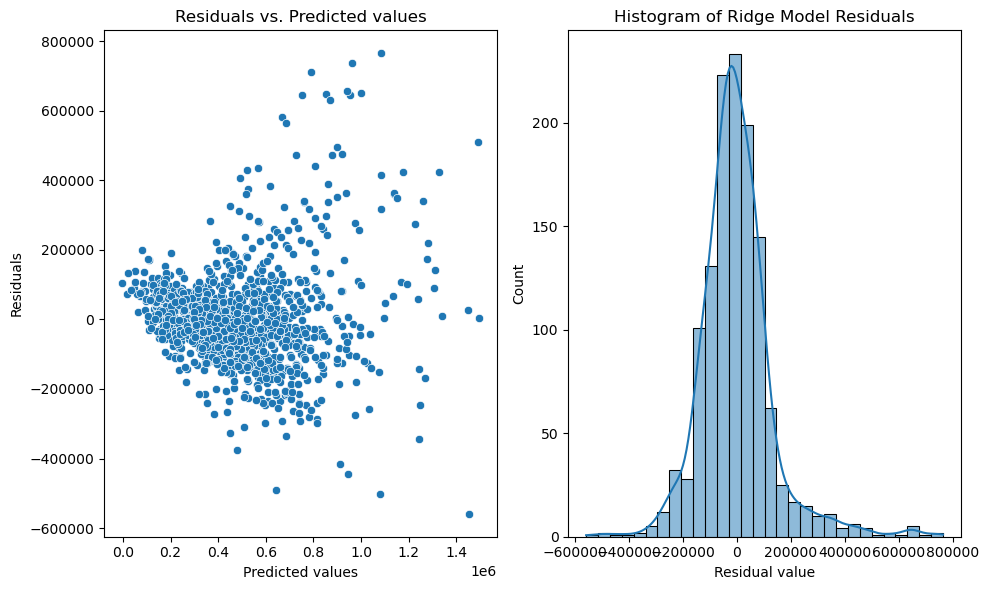

In [81]:
# splitting dependent variable and independent variables
X = df_model.drop(columns=['price_target'])
y = df_model['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
ridge = Ridge()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Rescaling y pred to original scale
# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Ridge Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Ridge-BOW Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'alpha': 51.79474679231202}
Mean Squared Error: 18630726432.539192
RMSE: 136494.41905271876
MAE: 95822.20081723572
Mean Absolute Percentage Error: [23.13556819]
R^2: 0.7557358660255876


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


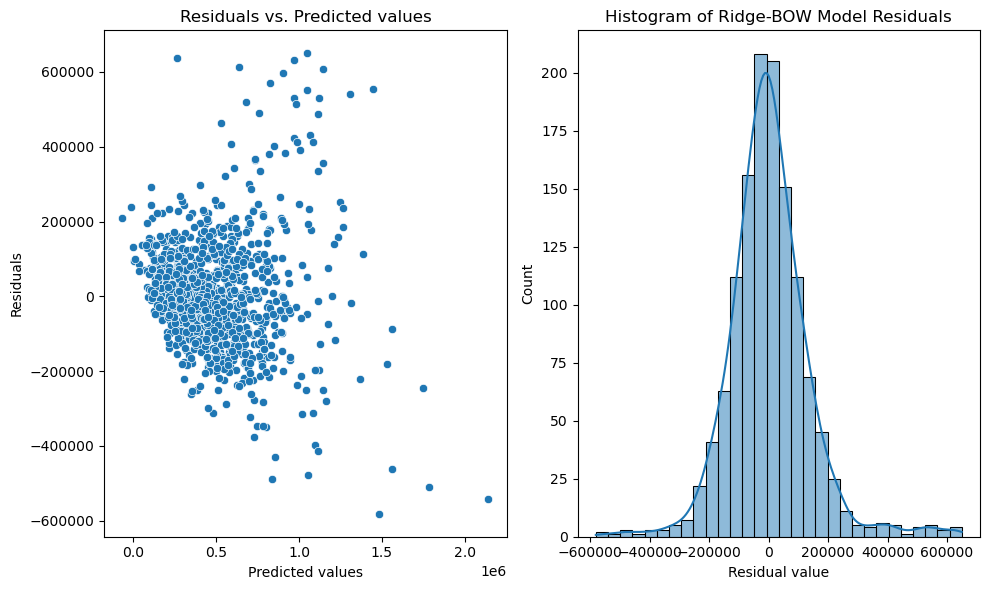

In [90]:
# splitting dependent variable and independent variables
X = bow_data.drop(columns=['price_target'])
y = bow_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
ridge_bow = Ridge()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=ridge_bow, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Rescaling y pred to original scale
# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Ridge-BOW Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Ridge-Doc

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Best Parameters: {'alpha': 0.8286427728546842}
Mean Squared Error: 17113699792.605103
RMSE: 130819.34028500947
MAE: 89571.44509875053
Mean Absolute Percentage Error: [21.58656142]
R^2: 0.7756253319442341


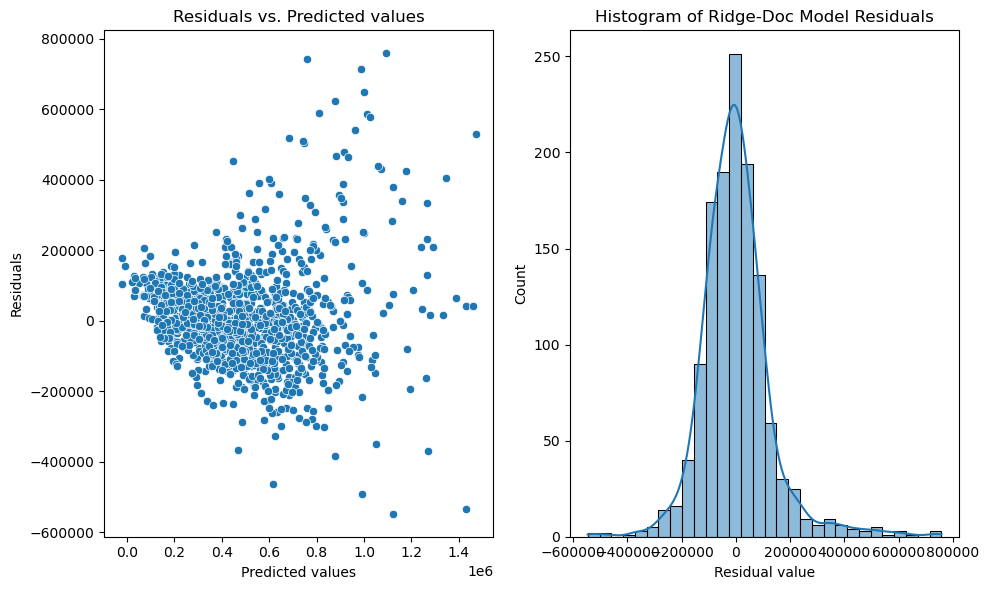

In [97]:
# splitting dependent variable and independent variables
X = doc2vec_data.drop(columns=['price_target'])
y = doc2vec_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
ridge_bert = Ridge()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=ridge_bert, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Rescaling y pred to original scale
# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Ridge-Doc Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Ridge-Bert

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best Parameters: {'alpha': 5.428675439323859}
Mean Squared Error: 15421072383.81041
RMSE: 124181.61048967922
MAE: 85095.60030974336
Mean Absolute Percentage Error: [20.79358408]
R^2: 0.7978170682486483


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


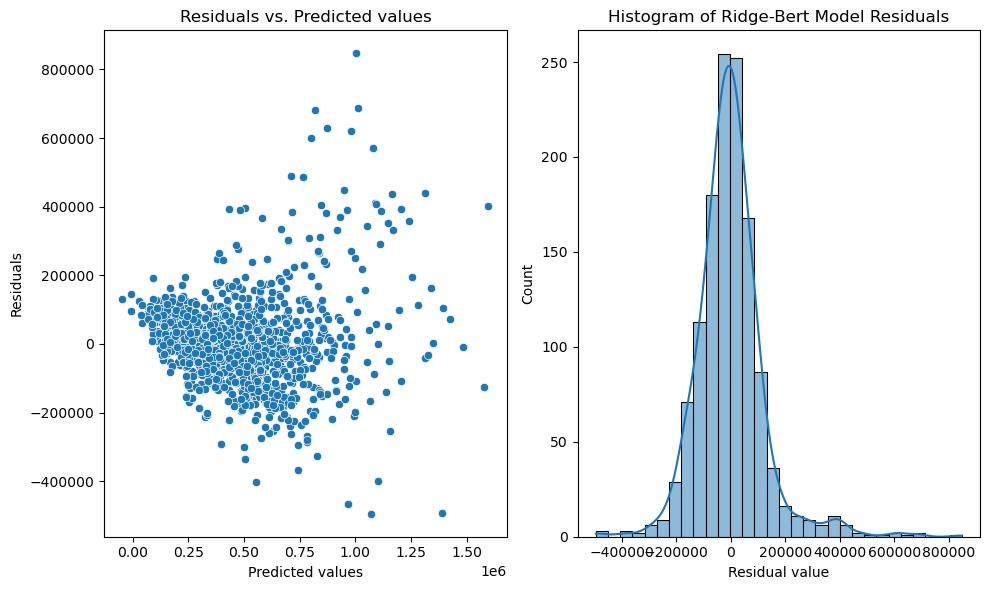

In [104]:
# splitting dependent variable and independent variables
X = bert_data.drop(columns=['price_target'])
y = bert_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
ridge_bert = Ridge()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=ridge_bert, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Rescaling y pred to original scale
# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Ridge-Bert Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Lasso Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'alpha': 0.0001}
Mean Squared Error: 18718431757.056534
RMSE: 136815.31989165736
MAE: 92425.96311292642
Mean Absolute Percentage Error: [21.84954465]
R^2: 0.7545859771462815


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


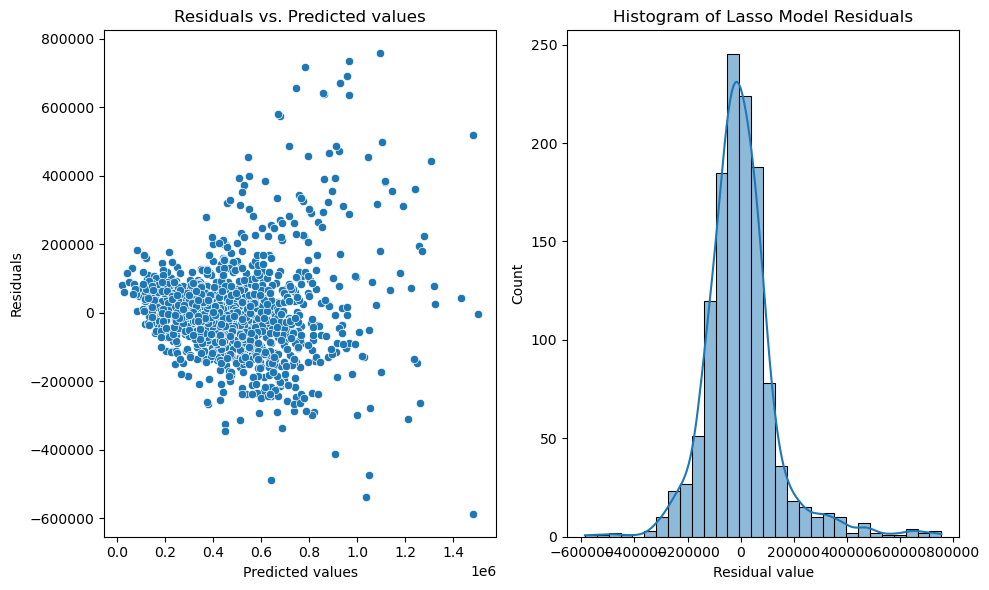

In [105]:
# splitting dependent variable and independent variables
X = df_model.drop(columns=['price_target'])
y = df_model['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
lasso = Lasso()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Lasso Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Lasso-Bow

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'alpha': 0.0004498432668969444}
Mean Squared Error: 15606903989.432543
RMSE: 124927.594987787
MAE: 84709.16503909627
Mean Absolute Percentage Error: [19.89679909]
R^2: 0.7953806631853929


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


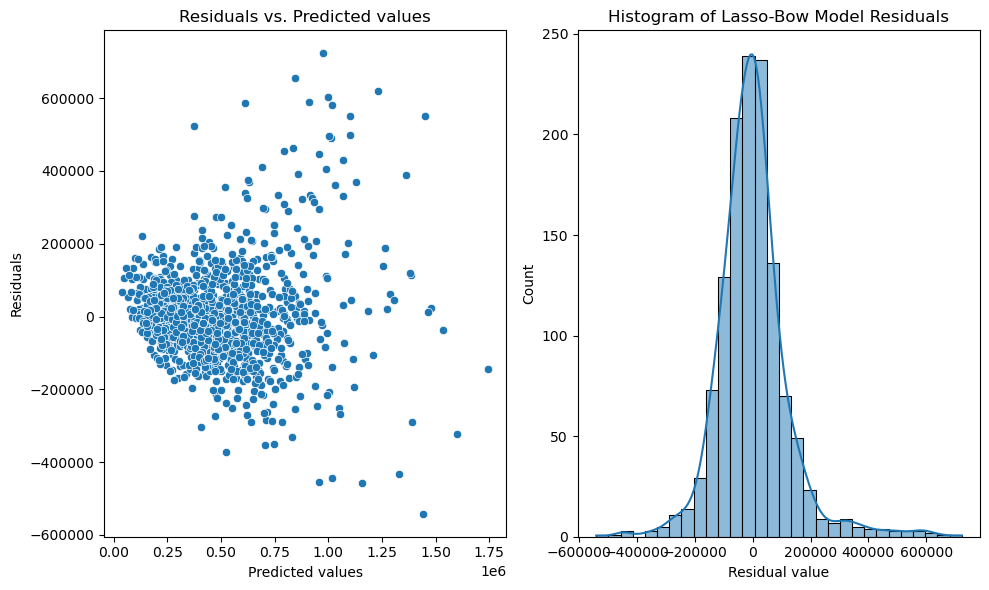

In [106]:
# splitting dependent variable and independent variables
X = bow_data.drop(columns=['price_target'])
y = bow_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
lasso_bow = Lasso()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lasso_bow, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Lasso-Bow Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Lasso-Doc

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Best Parameters: {'alpha': 0.0001}
Mean Squared Error: 17475809133.39303
RMSE: 132196.1010521605
MAE: 90191.0083731833
Mean Absolute Percentage Error: [21.55083828]
R^2: 0.7708777809106293


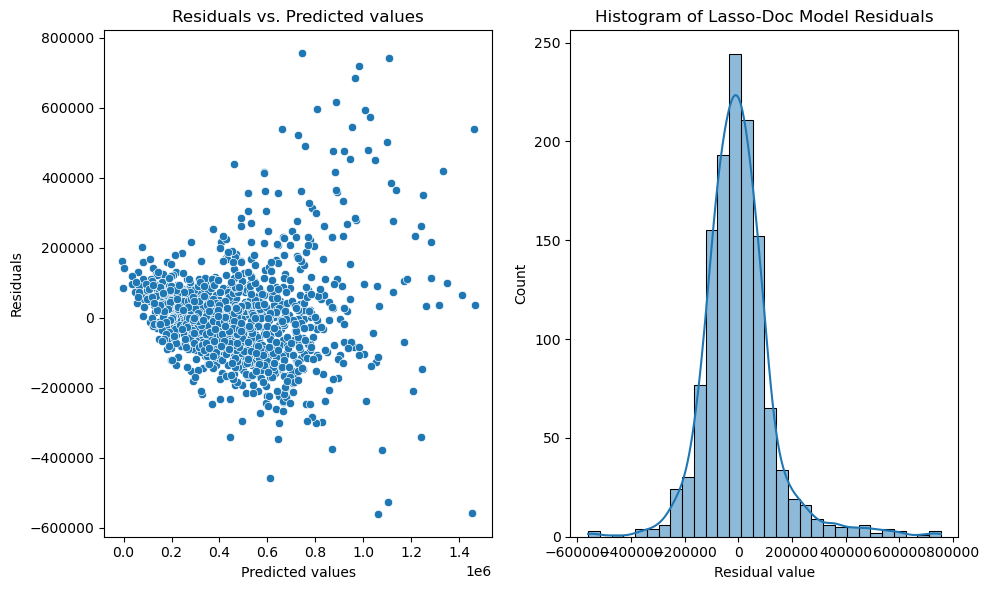

In [107]:
# splitting dependent variable and independent variables
X = doc2vec_data.drop(columns=['price_target'])
y = doc2vec_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
lasso_doc = Lasso()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lasso_doc, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Lasso-Doc Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show() 

### Lasso-Bert

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best Parameters: {'alpha': 0.0001}
Mean Squared Error: 15858262785.340557
RMSE: 125929.59455719913
MAE: 84703.26807514747
Mean Absolute Percentage Error: [20.36624911]
R^2: 0.7920851428082546


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


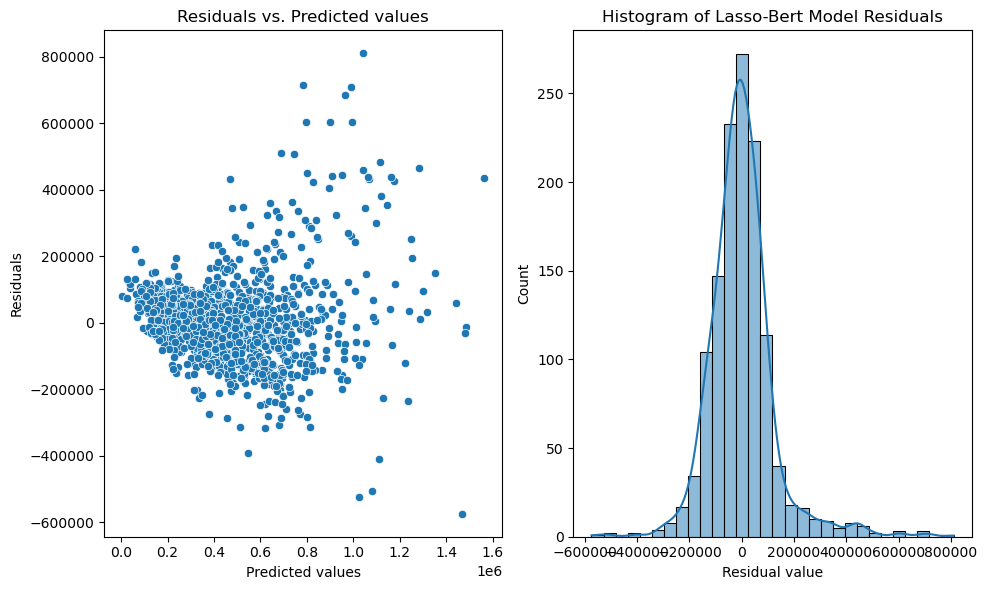

In [108]:
# splitting dependent variable and independent variables
X = bert_data.drop(columns=['price_target'])
y = bert_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
lasso_bert = Lasso()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lasso_bert, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Lasso-Bert Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Random Forest

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': True}
Mean Squared Error: 15160842361.77019
RMSE: 123129.37245746926
MAE: 76021.18677977119
Mean Absolute Percentage Error: [17.25451035]
R^2: 0.8012288976906168


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


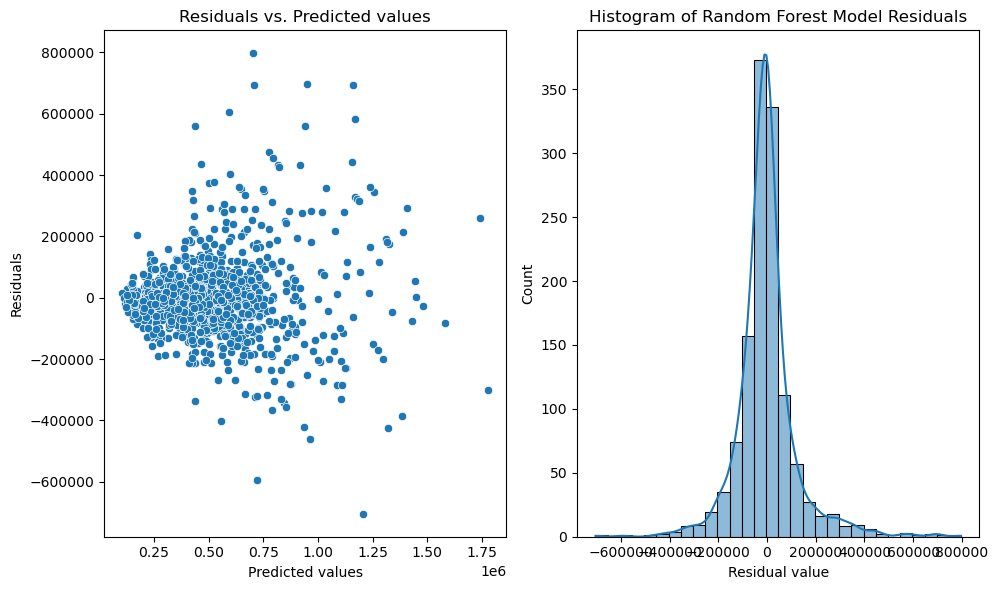

In [109]:
# splitting dependent variable and independent variables
X = df_model.drop(columns=['price_target'])
y = df_model['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Random Forest regressor
rf = RandomForestRegressor()

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False]
}


random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)
# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Random Forest Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Random Forest-Bow Model

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': True}
Mean Squared Error: 14676421654.075953
RMSE: 121146.28204809238
MAE: 76634.42337116608
Mean Absolute Percentage Error: [16.97230626]
R^2: 0.8075800512579593


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


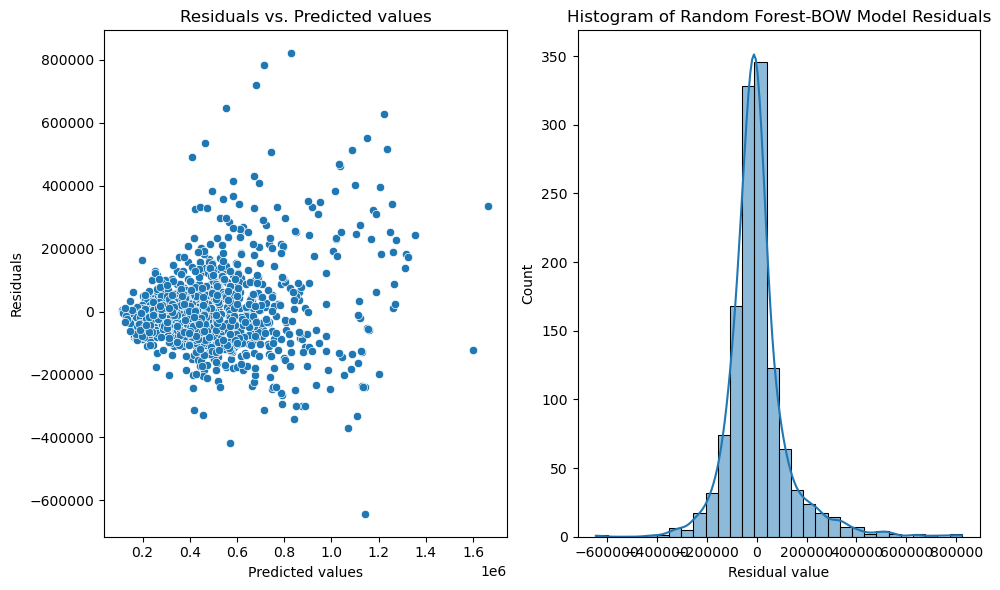

In [110]:
# splitting dependent variable and independent variables
X = bow_data.drop(columns=['price_target'])
y = bow_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Random Forest regressor
rf = RandomForestRegressor()

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False]
}


random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)
# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Random Forest-BOW Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Random Forest-Doc Model

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': True}
Mean Squared Error: 15348600401.017952
RMSE: 123889.46848307144
MAE: 79429.17121684867
Mean Absolute Percentage Error: [18.13343863]
R^2: 0.7987672354994159


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


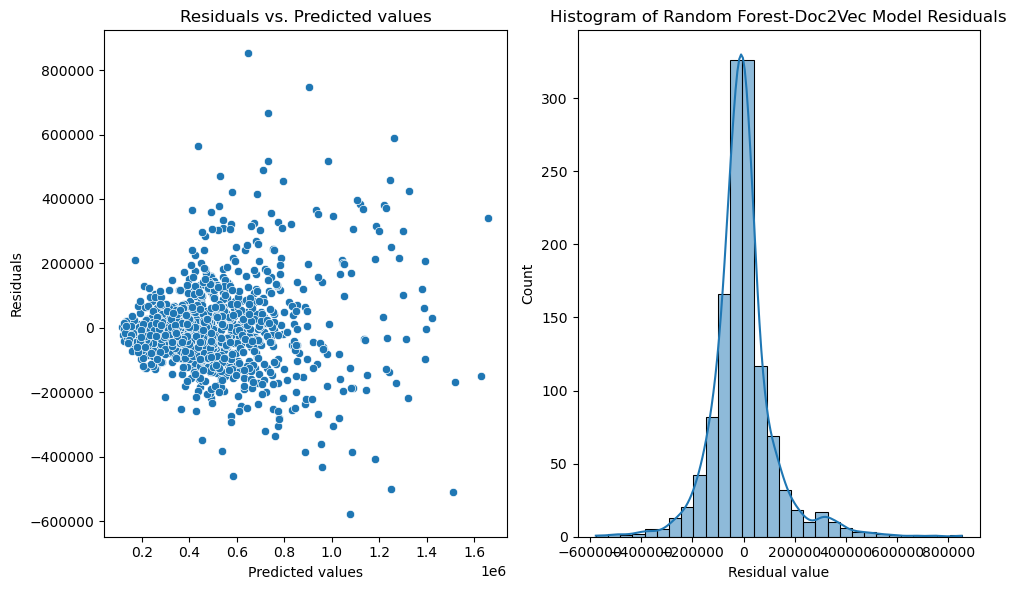

In [111]:
# splitting dependent variable and independent variables
X = doc2vec_data.drop(columns=['price_target'])
y = doc2vec_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Random Forest regressor
rf = RandomForestRegressor()

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False]
}


random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)
# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Random Forest-Doc2Vec Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Random Forest-Bert Model

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': True}
Mean Squared Error: 17186337855.172882
RMSE: 131096.67369988028
MAE: 85981.15464116287
Mean Absolute Percentage Error: [19.80492414]
R^2: 0.7746729872511303


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


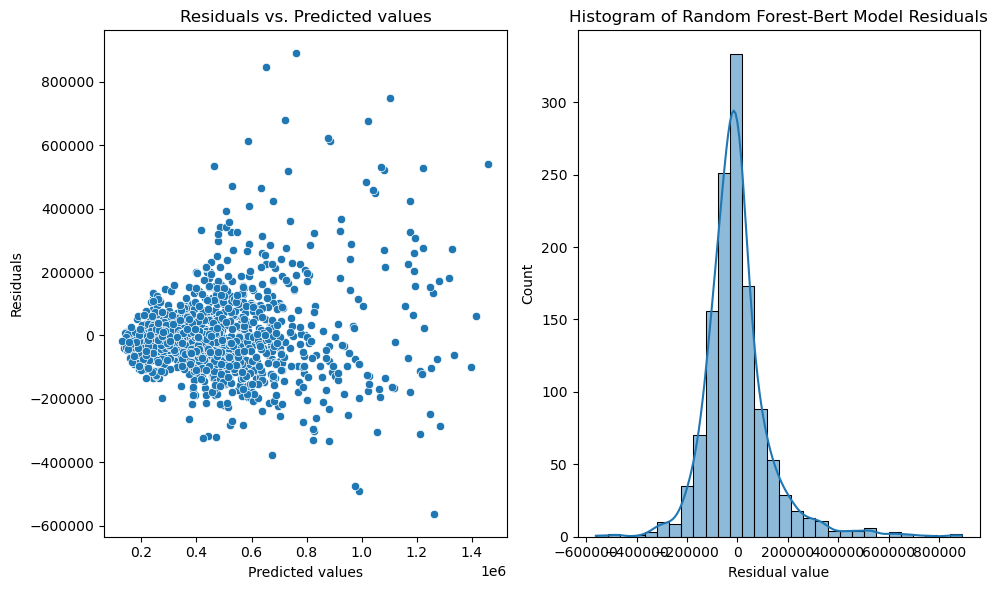

In [112]:
# splitting dependent variable and independent variables
X = bert_data.drop(columns=['price_target'])
y = bert_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Random Forest regressor
rf = RandomForestRegressor()

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False]
}


random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)
# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Random Forest-Bert Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### LightGBM

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 245, in _count_physical_cores
    raise ValueError(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2151
[LightGBM] [Info] Number of data points in the train set: 2989, number of used features: 61
[LightGBM] [Info] Start training from score 0.203566
Best Parameters: {'seed': 42, 'objective': 'regression', 'num_leaves': 15, 'n_estimators': 40, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}
Mean Squared Error: 15368071736.42924
RMSE: 123968.02707323062
MAE: 81159.99597741422
Mean Absolute Percentage Error: [19.2289655]
R^2: 0.7985119502909306


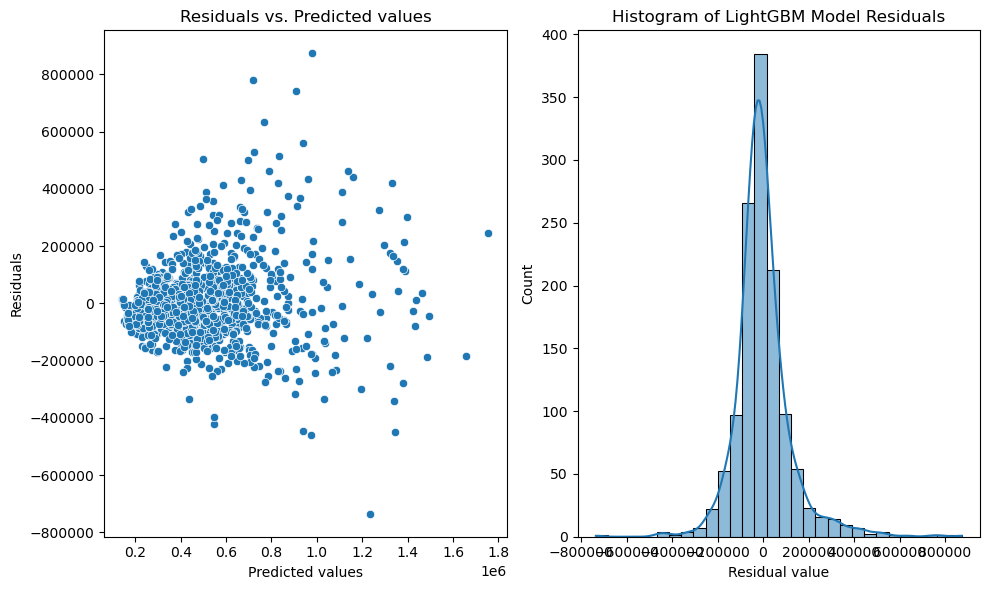

In [117]:
# splitting dependent variable and independent variables
X = df_model.drop(columns=['price_target'])
y = df_model['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define LightGBM regressor
model = lgb.LGBMRegressor()

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 40, 60],
    'num_leaves': [15, 31, 63, 127],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'],
    'seed': [42]
}

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of LightGBM Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### LightGBM-BOW

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9543
[LightGBM] [Info] Number of data points in the train set: 2989, number of used features: 1558
[LightGBM] [Info] Start training from score 0.203566
Best Parameters: {'seed': 42, 'objective': 'regression', 'num_leaves': 15, 'n_estimators': 40, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}
Mean Squared Error: 14330877268.820824
RMSE: 119711.64216073901
MAE: 78903.51696828147
Mean Absolute Percentage Error: [18.55348628]
R^2: 0.8121104221117039


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


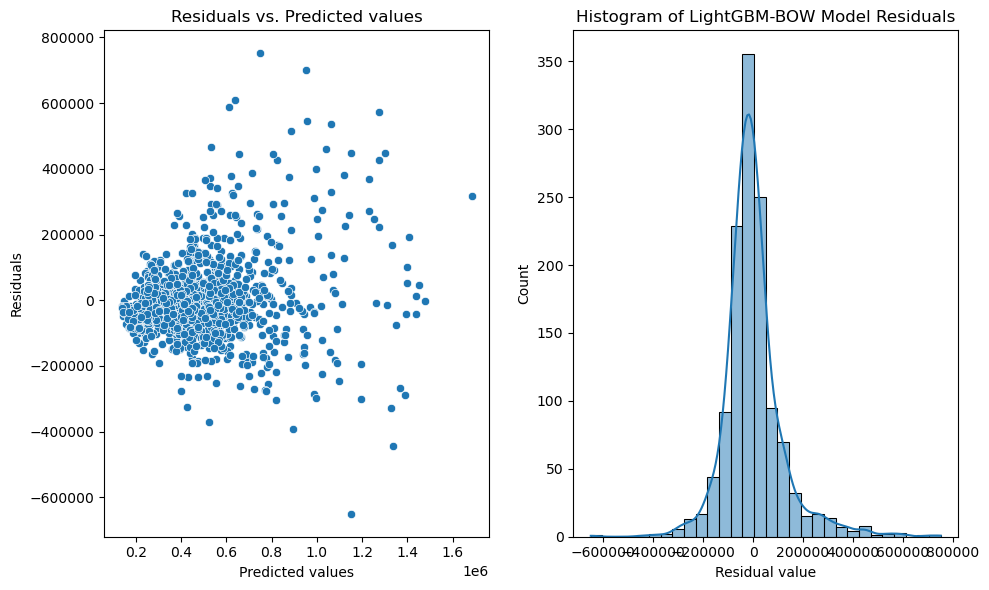

In [118]:
# splitting dependent variable and independent variables
X = bow_data.drop(columns=['price_target'])
y = bow_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define LightGBM regressor
model = lgb.LGBMRegressor()

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 40, 60],
    'num_leaves': [15, 31, 63, 127],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'],
    'seed': [42]
}

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of LightGBM-BOW Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### LightGBM-Doc

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7251
[LightGBM] [Info] Number of data points in the train set: 2989, number of used features: 81
[LightGBM] [Info] Start training from score 0.203566
Best Parameters: {'seed': 42, 'objective': 'regression', 'num_leaves': 15, 'n_estimators': 40, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}
Mean Squared Error: 14658380151.859446
RMSE: 121071.79750817052
MAE: 80570.39519613369
Mean Absolute Percentage Error: [19.1674996]
R^2: 0.8078165901782461


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


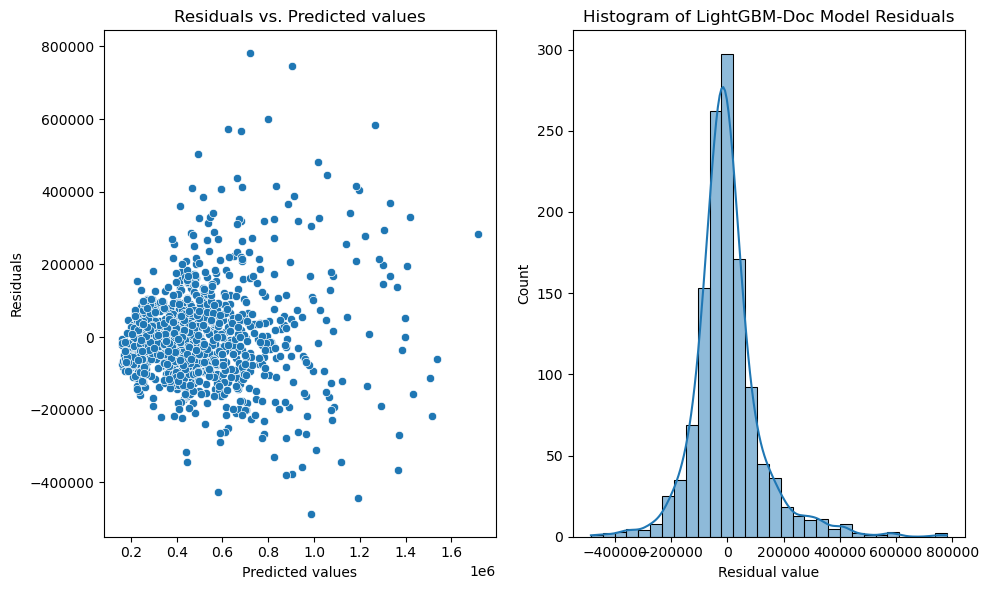

In [119]:
# splitting dependent variable and independent variables
X = doc2vec_data.drop(columns=['price_target'])
y = doc2vec_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define LightGBM regressor
model = lgb.LGBMRegressor()

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 40, 60],
    'num_leaves': [15, 31, 63, 127],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'],
    'seed': [42]
}

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of LightGBM-Doc Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### LightGBM-Bert

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197991
[LightGBM] [Info] Number of data points in the train set: 2989, number of used features: 829
[LightGBM] [Info] Start training from score 0.203566
Best Parameters: {'seed': 42, 'objective': 'regression', 'num_leaves': 15, 'n_estimators': 40, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}
Mean Squared Error: 15801272927.76547
RMSE: 125703.11423256574
MAE: 82870.20466270327
Mean Absolute Percentage Error: [19.79984488]
R^2: 0.7928323266744506


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


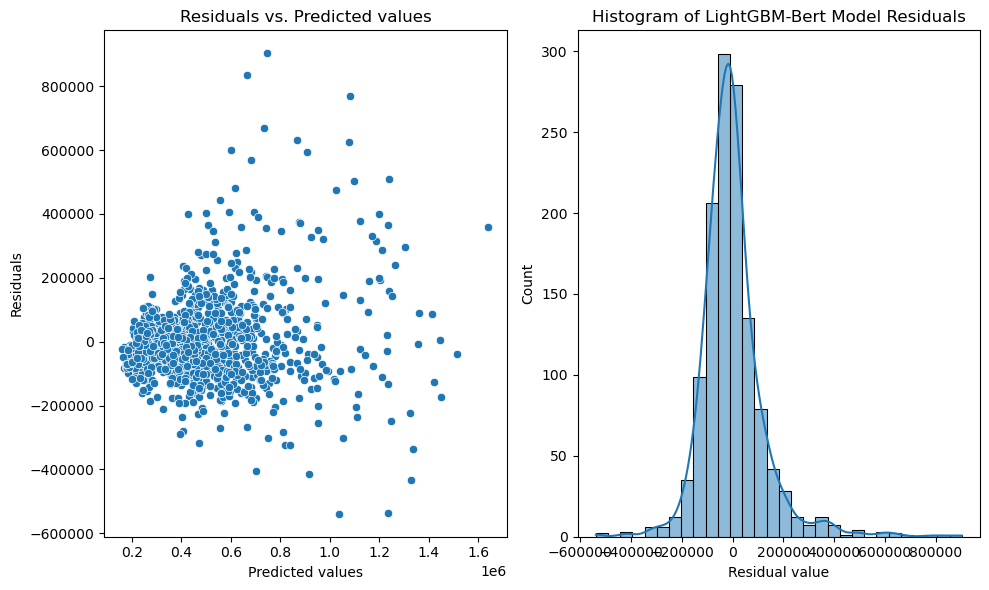

In [120]:
# splitting dependent variable and independent variables
X = bert_data.drop(columns=['price_target'])
y = bert_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define LightGBM regressor
model = lgb.LGBMRegressor()

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 40, 60],
    'num_leaves': [15, 31, 63, 127],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'],
    'seed': [42]
}

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of LightGBM-Bert Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()